# Single-Shot Readout Calibration for UA Q4

### Using Experiment and Analysis Class, make sure to update qubit #

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat, loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 3 # for UA Q4
res_index = 3 # for UA Q4
flux_index = 3 # for UA Q4
TLS_index = 0 # for TLS of interest

2024-02-29 13:18:21,802 - qm - INFO     - Starting session: 0ea52dd1-9f86-49a5-adf6-95306555bc84


In [2]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [3]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set DC voltage to sweet spot, after possible dc flux sweep
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)
machine = Analysis.set_machine(machine)
# set octave to external clock
#Experiment.set_external_clock()

In [4]:
# Set the qubit freq, in case I was working with something else
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[0] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50E6
machine = Analysis.set_machine(machine)

In [6]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)


2024-02-29 13:24:54,815 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-29 13:24:54,828 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
2024-02-29 13:25:02,589 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q3 for (LO, IF) = (5.966 GHz, -50.000 MHz)
2024-02-29 13:25:15,318 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## 1D resonator spectroscopy

In [9]:
%matplotlib qt
machine = Analysis.get_machine()
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-3E6,3E6 + 1.0,0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                           n_avg = 5E3, cd_time = 5E3, readout_state = 'g', simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 3.39s


resonator frequency: 6880.088 MHz
Execution stopped by user!


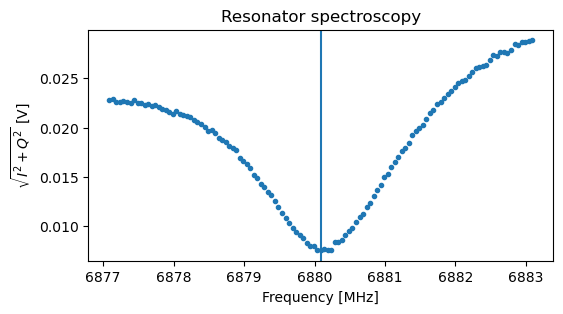

In [10]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
if True:
    machine.resonators[res_index].f_readout = res_freq.tolist() + 0E6
    machine.resonators[res_index].lo = machine.resonators[res_index].f_readout + 50E6
    machine = Analysis.set_machine(machine)

## 1D qubit spectroscopy

In [12]:
# for the DC flux
#qubit_freq_est = np.polyval(machine.qubits[qubit_index].DC_tuning_curve,machine.flux_lines[flux_index].max_frequency_point) * 1E6 # in Hz
# for the fast flux
qubit_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-30E6, 30E6 + 1, 0.5E6)
    
%matplotlib qt
machine, qubit_freq_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_freq(qubit_freq_sweep, qubit_index, res_index, flux_index, 
                                      pi_amp_rel = 1.0, ff_amp = 0.0, n_avg = 5E3, cd_time = 20E3, plot_flag = True, 
                                      simulate_flag = False, simulation_len = 4000)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 12.61s


resonant frequency: 5916.706 MHz


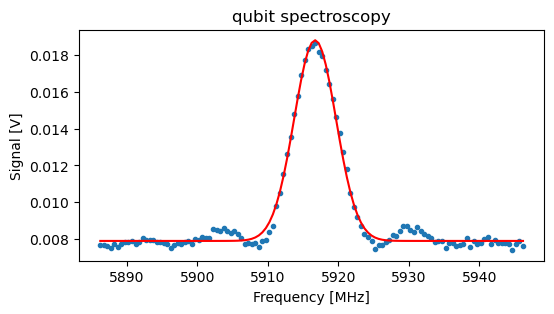

In [14]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=qubit_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq + 50E6
machine = Analysis.set_machine(machine)

## Measure single-shot I, Q blobs

In [50]:
%matplotlib inline
machine, Ig, Qg, Ie, Qe = Experiment.exp1D.RR.single_shot_IQ_blob(machine.resonators[res_index].f_readout, qubit_index, res_index, flux_index,
                              n_avg = 150E3, cd_time = 20E3, plot_flag = False)


			Fidelity Matrix:
			-----------------
			| 0.920 | 0.080 |
			----------------
			| 0.138 | 0.862 |
			-----------------
			IQ plane rotated by: 29.6°
			Threshold: 2.491e-03
			Fidelity: 89.1%
			


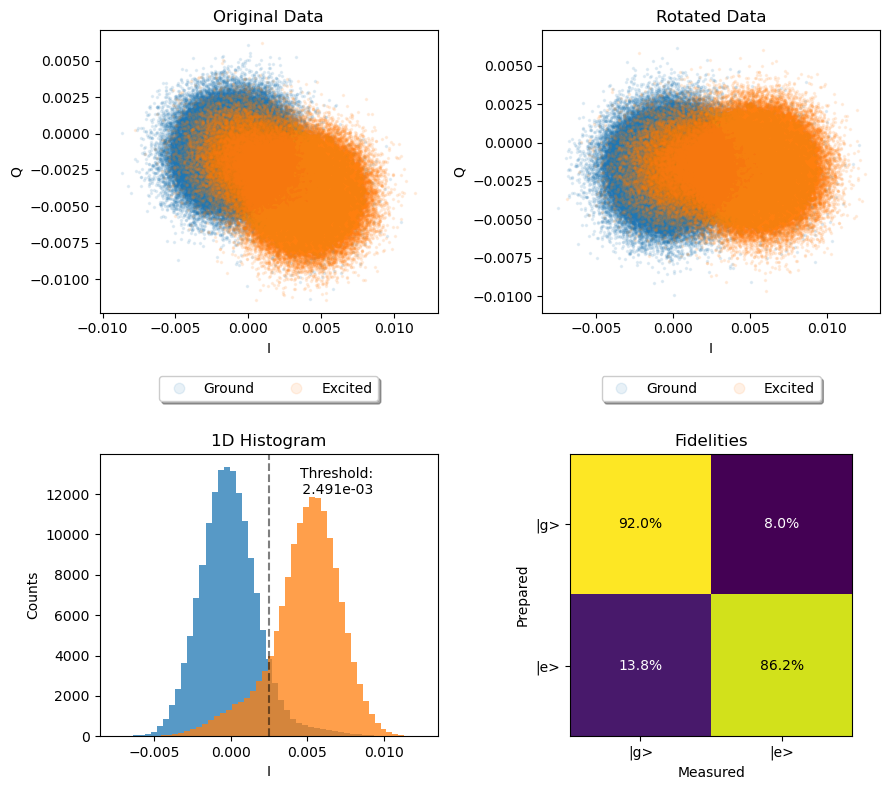

In [53]:
angle, threshold, fidelity, gg, ge, eg, ee = Analysis.exp1D.two_state_discriminator(Ig, Qg, Ie, Qe, plot_flag=True)

In [54]:
# set the rotation angle
machine.resonators[res_index].rotation_angle -= angle.item()
machine.resonators[res_index].ge_threshold = threshold.item()
machine = Analysis.set_machine(machine)

## optimize single-shot frequency

In [43]:
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-3E6, 3E6 + 1, 0.05E6)

%matplotlib qt
machine, SNR, res_freq_opt = Experiment.exp1D.RR.single_shot_freq_optimization(res_freq_sweep, qubit_index, res_index, flux_index,
                              n_avg = 50E3, cd_time = 20E3, plot_flag = True)

Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 255.88s
The optimal readout frequency is 6879737801.0 Hz (SNR=3.3181321809996436)
Execution stopped by user!


In [44]:
machine.resonators[res_index].f_readout = res_freq_opt.tolist() + 0E6
machine.resonators[res_index].lo = machine.resonators[res_index].f_readout + 50E6
machine = Analysis.set_machine(machine)

In [45]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-02-29 13:55:21,006 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-29 13:55:21,015 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
2024-02-29 13:55:28,100 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q3 for (LO, IF) = (5.967 GHz, -50.000 MHz)
2024-02-29 13:55:40,917 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## optimize single-shot amplitude

In [48]:
res_amp_sweep = np.arange(0.5,1.5 + 1E-4, 0.01)

%matplotlib qt
machine, res_amp_sweep_abs, fidelity, res_amp_opt = Experiment.exp1D.RR.single_shot_amp_optimization(res_amp_sweep, qubit_index, res_index, flux_index,
                              n_avg = 40E3, cd_time = 20E3, plot_flag = True)

some abs amps > 0.5, removed from experiment run
Progress: [##################################################] 100.0% (n=57/57) --> elapsed time: 94.26s
Progress: [##################################################] 100.0% (n=57/57) --> elapsed time: 94.29s
Progress: [##################################################] 100.0% (n=57/57) --> elapsed time: 94.31s
Progress: [##################################################] 100.0% (n=57/57) --> elapsed time: 94.34s
Progress: [##################################################] 100.0% (n=57/57) --> elapsed time: 94.36s
Progress: [##################################################] 100.0% (n=57/57) --> elapsed time: 94.38s
Progress: [##################################################] 100.0% (n=57/57) --> elapsed time: 94.41s
Progress: [##################################################] 100.0% (n=57/57) --> elapsed time: 94.43s
Progress: [##################################################] 100.0% (n=57/57) --> elapsed time: 94.45s
Progre

Progress: [##################################################] 100.0% (n=57/57) --> elapsed time: 96.29s
Progress: [##################################################] 100.0% (n=57/57) --> elapsed time: 96.31s
Progress: [##################################################] 100.0% (n=57/57) --> elapsed time: 96.33s
Progress: [##################################################] 100.0% (n=57/57) --> elapsed time: 96.95s
Progress: [##################################################] 100.0% (n=57/57) --> elapsed time: 96.97s
The optimal readout amplitude is 469.000 mV (Fidelity=89.3%)


In [49]:
machine.resonators[res_index].readout_pulse_amp = 0.459
machine = Analysis.set_machine(machine)

## optimize single-shot readout duration

In [36]:
readout_len = 3E3
ringdown_len = 1E3
division_length = 10

%matplotlib qt
machine, res_duration_sweep, SNR, opt_readout_length = Experiment.exp1D.RR.single_shot_duration_optimization(readout_len, ringdown_len, division_length, 
                            qubit_index, res_index, flux_index, n_avg = 20E3, cd_time = 20E3, plot_flag = True)

Integration weights chunk-size length in clock cycles: 10
The readout has been sliced in the following number of divisions 100
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 8.27s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 8.69s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 9.10s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 9.48s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 9.87s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 10.25s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 10.67s
Progress: [##################################################] 100.0% (n=20000/20000.0)

In [39]:
machine.resonators[res_index].readout_pulse_length = 992
machine = Analysis.set_machine(machine)